In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.
import matplotlib.colors as mcolors

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import time
import os

torch.cuda.empty_cache()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [3]:
path = "aptos2019-blindness-detection/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


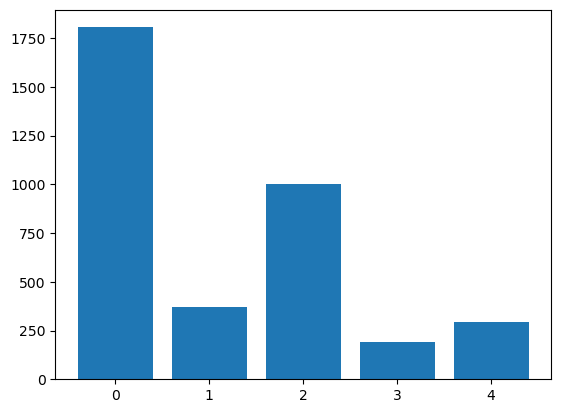

In [4]:
bins = np.arange(-0.5, max(train_df.diagnosis) + 1.5, 1)

# Plot histogram with adjusted bins
plt.hist(train_df.diagnosis, bins=bins, rwidth=0.8, align='mid')

# Set x-ticks to be at the center of each bar
plt.xticks(np.arange(0, 5, 1))

# Turn off the grid or adjust it
plt.grid(False)

# Show the plot
plt.show()

In [5]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


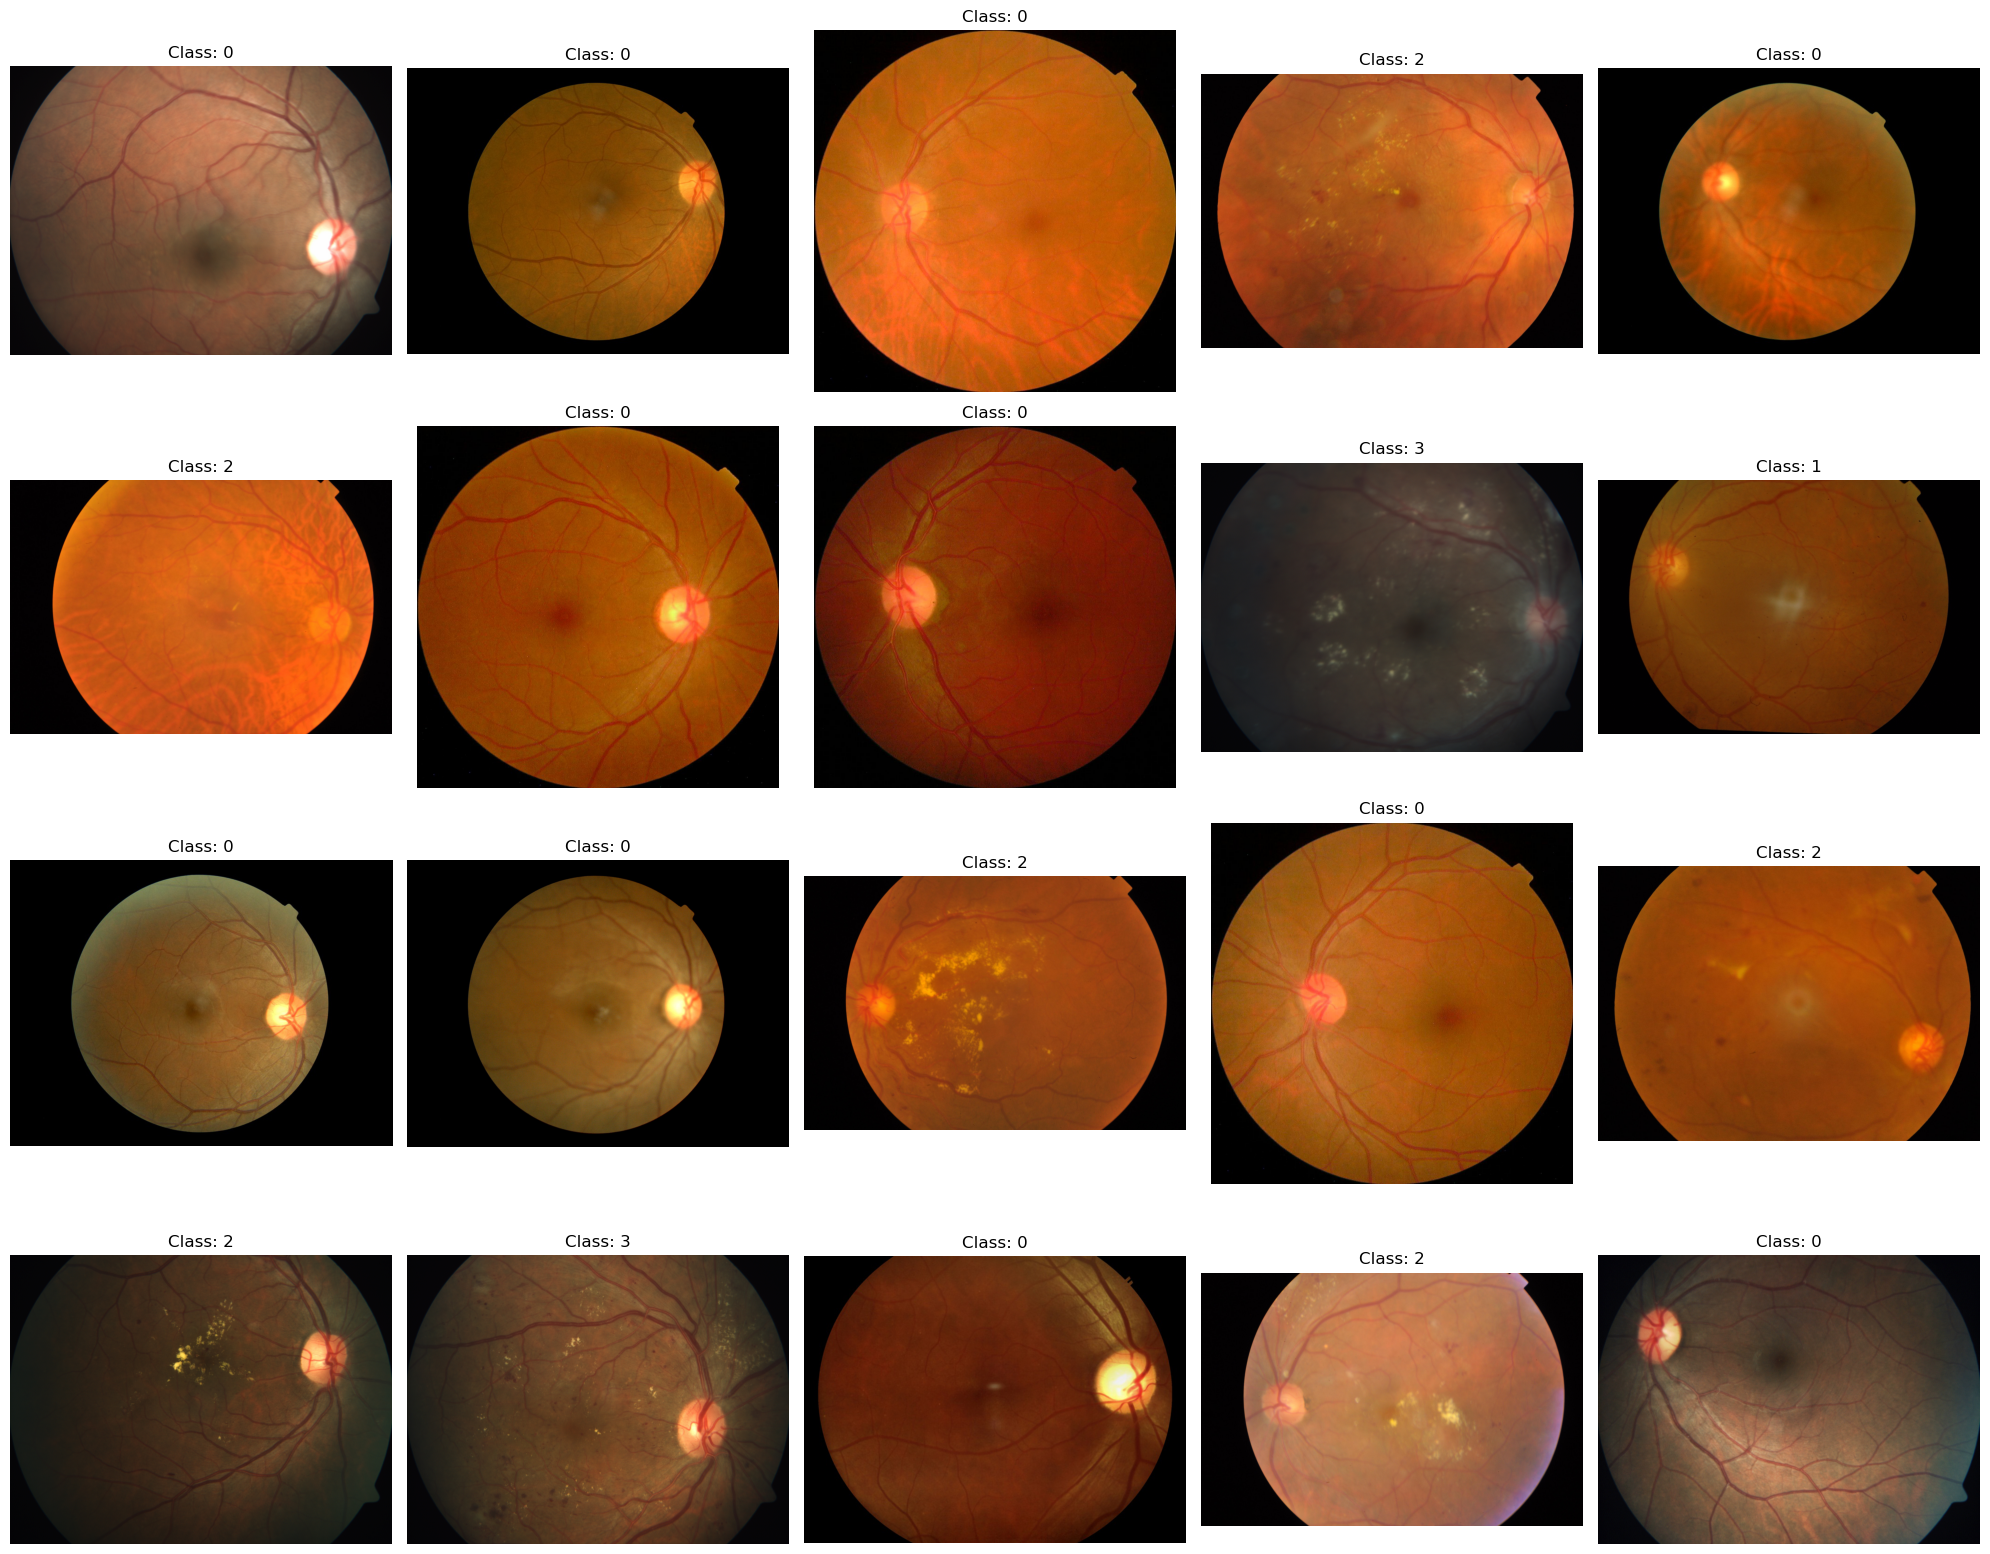

In [6]:
# Set the number of images to display
num_images = 20

# Generate a list of random indices based on the DataFrame length
random_indices = np.random.randint(0, len(train_df), size=num_images)

# Set up the plot - adjust subplot grid as needed
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16)) # Adjust nrows and ncols based on num_images
axes = axes.flatten()

for i, ax in zip(random_indices, axes):
    # Construct the full path to the image
    sample_image_path = f'{path}train_images/{train_df["id_code"][i]}.png'
    sample_image = Image.open(sample_image_path)
    
    # Plotting
    ax.imshow(sample_image)
    ax.axis('off') # Hides the axis
    ax.set_title(f'Class: {train_df["diagnosis"][i]}') # Shows the class of each image

# Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()
plt.show()

In [7]:
class BackgroundRemoval:
    def __call__(self, img):
        # Convert image to grayscale for thresholding
        gray = img.convert('L')
        img_array = np.array(gray)

        # Create a binary mask where non-black pixels are set to 255 (non-transparent)
        threshold = 10
        mask = np.where(img_array > threshold, 255, 0).astype(np.uint8)

        # Convert the numpy array mask to a PIL Image
        mask_image = Image.fromarray(mask, mode='L')

        # Apply this mask to the original image to make the background transparent
        img.putalpha(mask_image)

        return img

In [8]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [11]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [12]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        return self.up(x)

In [13]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=5):  # Change from 3 to 4 for RGBA
        super(AttentionUNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)

        self.up1 = UpConv(512, 256)
        self.att1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.up_conv1 = DoubleConv(512, 256)

        self.up2 = UpConv(256, 128)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.up_conv2 = DoubleConv(256, 128)

        self.up3 = UpConv(128, 64)
        self.att3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.up_conv3 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, out_channels)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = F.max_pool2d(self.down1(x1), 2)
        x3 = F.max_pool2d(self.down2(x2), 2)
        x4 = F.max_pool2d(self.down3(x3), 2)

        # Decoder path
        x = self.up1(x4)
        g1 = self.att1(x, x3)
        x = self.up_conv1(torch.cat([x, g1], dim=1))

        x = self.up2(x)
        g2 = self.att2(x, x2)
        x = self.up_conv2(torch.cat([x, g2], dim=1))

        x = self.up3(x)
        g3 = self.att3(x, x1)
        x = self.up_conv3(torch.cat([x, g3], dim=1))

        x = self.global_avg_pool(x)  # Collapse spatial dimensions
        x = x.view(x.size(0), -1)  # Flatten
        logits = self.classifier(x)
        return logits

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [15]:
image_transform = transforms.Compose([BackgroundRemoval(),
                                      transforms.Resize([256, 256]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406, 0), (0.229, 0.224, 0.225, 1))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_size = int(0.9 * len(data_set))
valid_size = len(data_set) - train_size

train_set, valid_set = torch.utils.data.random_split(data_set, [train_size, valid_size])

In [16]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4) #DataLoader for validation_set.

In [17]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

In [18]:
def evaluate_model(dataloader, model, criterion):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    metrics = calculate_metrics(y_true, y_pred)
    return epoch_loss, metrics[0], metrics[1], metrics[2], metrics[3]

In [19]:
model = AttentionUNet() 
model = model.to(device) #Moves the model to the device.

In [20]:
def generate_saliency_maps(model, dataloader, epoch, device, save_dir, num_images=20):
    model.eval()
    epoch_dir = os.path.join(save_dir, f'Epoch_{epoch+1}')
    os.makedirs(epoch_dir, exist_ok=True)

    total_images_processed = 0
    images_processed = 0

    # Create a custom thermal-like colormap from blue to red
    colors = [(0, 0, 1, 1)] + [(x, 0, 1-x, 1) for x in np.linspace(0, 1, 128)] + [(1, x, 0, 1) for x in np.linspace(0, 1, 127)]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_thermal', colors, N=256)

    # Iterate over all batches
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)

        for idx in range(images.size(0)):
            if images_processed < num_images:
                image = images[idx].unsqueeze(0)
                image.requires_grad = True

                # Forward pass
                outputs = model(image)
                score, predicted = torch.max(outputs, 1)

                # Backward pass
                model.zero_grad()
                score.backward()

                # Saliency map computation
                saliency = image.grad.data.abs().squeeze()
                saliency = saliency.sum(dim=0)  # Sum across the color channels to get a 2D saliency map
                saliency = saliency / saliency.max()  # Normalize

                # Normalize the original image for display
                original_img = image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
                original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

                # Plotting
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                # Original image
                ax[0].imshow(original_img)
                ax[0].set_title('Original Image')
                ax[0].axis('off')

                # Saliency map
                ax[1].imshow(saliency.cpu(), cmap=cmap)
                ax[1].set_title('Saliency Map')
                ax[1].axis('off')

                plt.suptitle(f'Actual: {labels[idx].item()}, Predicted: {predicted.item()}')
                plt.savefig(os.path.join(epoch_dir, f'Saliency_{total_images_processed}.png'))
                plt.close()

                images_processed += 1
            total_images_processed += 1

            if images_processed >= num_images:
                break
        if images_processed >= num_images:
            break


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=10, verbose=True)

# Compute class weights and convert to tensor
class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'].values), dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 45

# Initialize lists to store metrics for plotting later
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
train_precision, valid_precision = [], []
train_recall, valid_recall = [], []
train_f1, valid_f1 = [], []

total_time = 0  # Initialize total time taken

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    start_time = time.time()  # Start time of the epoch

    # Lists to collect true and predicted labels for this epoch
    train_true_labels = []
    train_predicted_labels = []

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Collect labels and predictions
        train_true_labels.extend(labels.cpu().numpy())
        train_predicted_labels.extend(predicted.cpu().numpy())

    epoch_duration = time.time() - start_time  # Calculate duration of epoch
    total_time += epoch_duration  # Update the total time taken
    
    # Compute and store training metrics
    training_loss = running_loss / len(train_dataloader)
    training_accuracy = 100 * train_correct / train_total
    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy)
    
    # Compute and store additional training metrics (precision, recall, F1)
    train_metrics = calculate_metrics(train_true_labels, train_predicted_labels)
    train_precision.append(train_metrics[1])
    train_recall.append(train_metrics[2])
    train_f1.append(train_metrics[3])

    # Validation phase
    model.eval()
    valid_metrics = evaluate_model(valid_dataloader, model, criterion)
    
    # Extract and store validation metrics
    validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1 = valid_metrics
    valid_losses.append(validation_loss)
    valid_accuracies.append(validation_accuracy)
    valid_precision.append(validation_precision)
    valid_recall.append(validation_recall)
    valid_f1.append(validation_f1)
    
    scheduler.step(validation_loss)
    
    # Print training and validation results
    print(f'Training and Validation Metrics for Epoch {epoch+1}/{num_epochs}')
    print('-------------------------------')
    print(f'Training - Loss: {training_loss:.4f}, Acc: {training_accuracy:.2f}%, Prec: {train_metrics[1]:.4f}, Rec: {train_metrics[2]:.4f}, F1: {train_metrics[3]:.4f}')
    print(f'Validation - Loss: {validation_loss:.4f}, Acc: {validation_accuracy:.2f}%, Prec: {validation_precision:.4f}, Rec: {validation_recall:.4f}, F1: {validation_f1:.4f}')
    print(f'Epoch Duration: {epoch_duration:.2f} seconds, Total Time Elapsed: {total_time:.2f} seconds')
    # Generate saliency maps at the end of each epoch
    generate_saliency_maps(model, valid_dataloader, epoch, device, 'v4_saliency_maps')
    print(f'Epoch {epoch+1} completed. Saliency maps generated.')
    
    if early_stopping(validation_loss, model):
        print("Early stopping triggered.")
        break
        
    torch.cuda.empty_cache()

print(f'Total Training Time: {total_time:.2f} seconds')


Training and Validation Metrics for Epoch 1/45
-------------------------------
Training - Loss: 1.4885, Acc: 46.31%, Prec: 0.4880, Rec: 0.4631, F1: 0.4654
Validation - Loss: 1.5800, Acc: 51.50%, Prec: 0.5298, Rec: 0.5150, F1: 0.4852
Epoch Duration: 187.41 seconds, Total Time Elapsed: 187.41 seconds
Epoch 1 completed. Saliency maps generated.
Training and Validation Metrics for Epoch 2/45
-------------------------------
Training - Loss: 1.3866, Acc: 55.87%, Prec: 0.5711, Rec: 0.5587, F1: 0.5570
Validation - Loss: 1.3739, Acc: 60.22%, Prec: 0.5808, Rec: 0.6022, F1: 0.5806
Epoch Duration: 173.85 seconds, Total Time Elapsed: 361.26 seconds
Epoch 2 completed. Saliency maps generated.
Training and Validation Metrics for Epoch 3/45
-------------------------------
Training - Loss: 1.3117, Acc: 60.49%, Prec: 0.6167, Rec: 0.6049, F1: 0.6055
Validation - Loss: 1.4378, Acc: 64.58%, Prec: 0.5926, Rec: 0.6458, F1: 0.6093
Epoch Duration: 163.58 seconds, Total Time Elapsed: 524.83 seconds
Epoch 3 comp

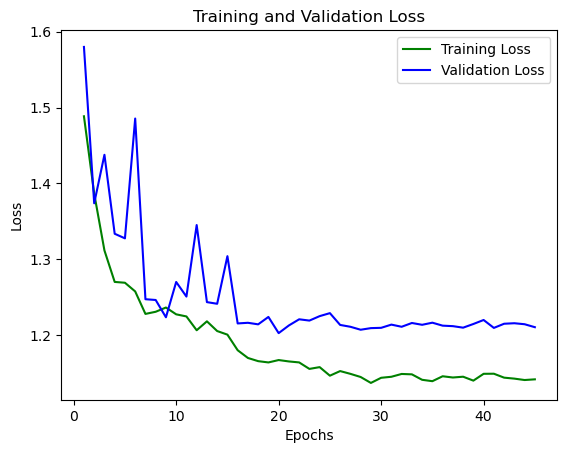

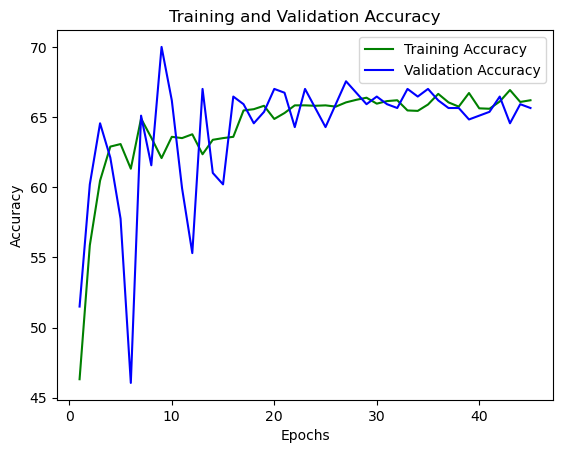

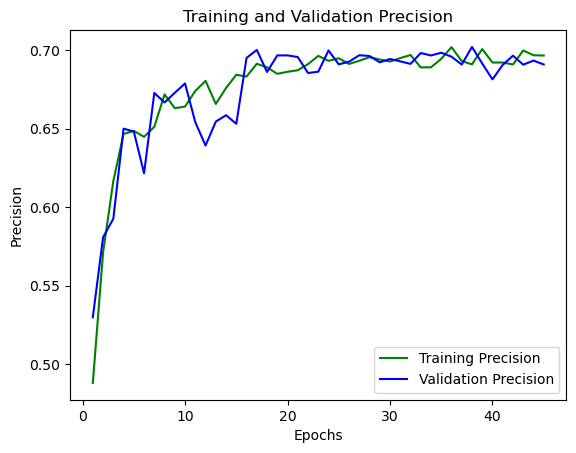

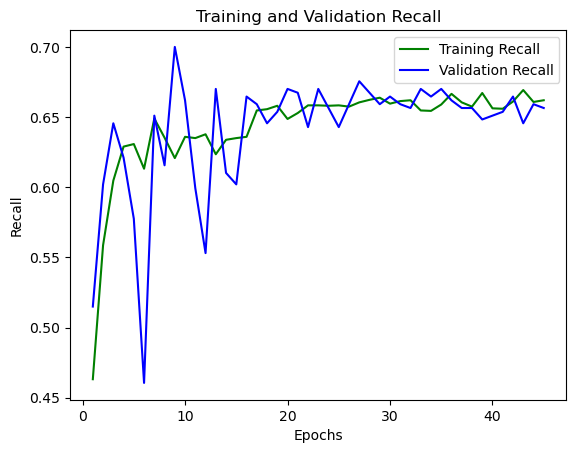

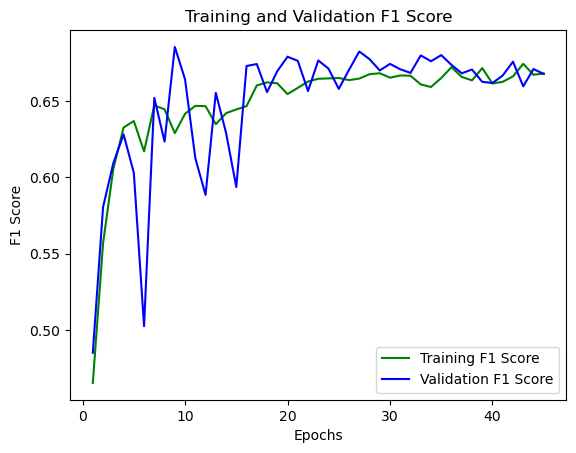

In [22]:
# After training, plot graphs for all metrics
def plot_metrics(train_metrics, valid_metrics, metric_name):
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_metrics, 'g', label=f'Training {metric_name}')
    plt.plot(epochs, valid_metrics, 'b', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(train_losses, valid_losses, 'Loss')
plot_metrics(train_accuracies, valid_accuracies, 'Accuracy')
plot_metrics(train_precision, valid_precision, 'Precision')
plot_metrics(train_recall, valid_recall, 'Recall')
plot_metrics(train_f1, valid_f1, 'F1 Score')